# Training the SPOCK model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
sys.path.append('../spock/')
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

Start by loading the training data generated with oldReboundTrainData.ipynb

In [2]:
#load datapath for clean training data
datapath = '../../cleanData/csvs/resonant/'

dataset = pd.read_csv(datapath+'OldReboundCleanResTrainingData.csv')
#remove junk columns
dataset = dataset.drop(columns=['Unnamed: 0','Unnamed: 0.1'])

We can then split the data into training and testing sets, note, we will remove systems that go unstable in 1e4 orbits from the testing set

In [3]:
def train_test(dataset,features):
    '''divides the dataset into 80% training and 20% testing and returns training/testing sets'''
    Nrows = int(0.8*dataset.shape[0])
    train = dataset.iloc[:Nrows, :]
    test = dataset.iloc[Nrows:, :]
    #remove testing systems that go unstable in 1e4 orbits
    test = test.drop(test[test['instability_time']<=1e4].index)
    return train[features], train['Stable'], test[features], test['Stable']

In [4]:
near = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear']
far = ['EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar']
megno = ['MEGNO', 'MEGNOstd']

features = near + far + megno

trainX, trainY, testX, testY = train_test(dataset, features)

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)

# Tuning hyperparameter
We can determine the idea values for the different hyperparameters.

We will start by creating and testing a collection of models that have randomly selected hyperparameters

scale_pos_weight is a hyperparameter used to account for skewed training data, it does this by weighting false positives and negatives differently. A typical value can be obtained by dividing your negative outcomes in your training data by your positive outcomes.

In [5]:
trainingBalance = trainY.value_counts()[False]/trainY.value_counts()[True]

We can then establish the different parameter space that we will be testing different hyperparameter values within.

In [6]:
space ={'max_depth': hp.qloguniform('x_max_depth', np.log(5), np.log(40), 1),
        'min_child_weight': hp.loguniform('x_min_child', 0, np.log(30)),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
}

def objective(params):
    clf = XGBClassifier(n_estimators = 75,
                            max_depth = int(params['max_depth']), 
                            min_child_weight = params['min_child_weight'],
                            subsample = params['subsample'],
                            learning_rate = 0.15, seed = 0,
                            scale_pos_weight = trainingBalance)
    
    score = xgb.cv(clf.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    print("SCORE:", avg_score, "ERROR", error)#, "HOLDOUT SCORE", test_score)
    return{'loss':1-avg_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error}


We can then create and evaluate the different trials

In [7]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 100, trials = trials, rstate=np.random.default_rng(seed=0))
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                                 
0.9288917703136187                                     
ERROR                                                  
0.001682115520105079                                   
SCORE:                                                                            
0.9289907334300752                                                                
ERROR                                                                             
0.0017481923343683607                                                             
SCORE:                                                                            
0.9336242336112386                                                                
ERROR                                                                             
0.001775118595493105                                                              
SCORE:                                                                            
0.9272800631071554           

We can not determine what values for hyperparameters will be ideal. We can do this by plotting how AUC changes as we alter each hyperparameter.

Here we will find that an optimal max_depth would be 15, which gives the best performance without over fitting.

Text(0, 0.5, 'CV AUC')

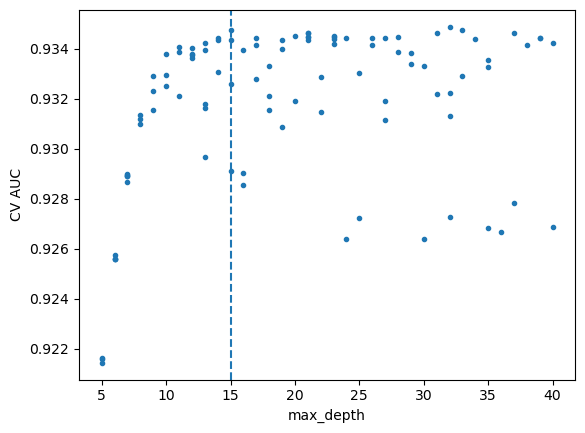

In [8]:
depths = trials.vals['x_max_depth']
min_childs = trials.vals['x_min_child']
subsample = trials.vals['x_subsample']
aucs = np.array([1-x['loss'] for x in trials.results])
fig, ax = plt.subplots()
ax.plot(depths, aucs, '.')
ax.axvline(15, linestyle='--')
ax.set_xlabel('max_depth')
ax.set_ylabel('CV AUC')

Here we will find that an optimal min_childs would be 10, which gives the best performance without over fitting.

Text(0, 0.5, 'CV AUC')

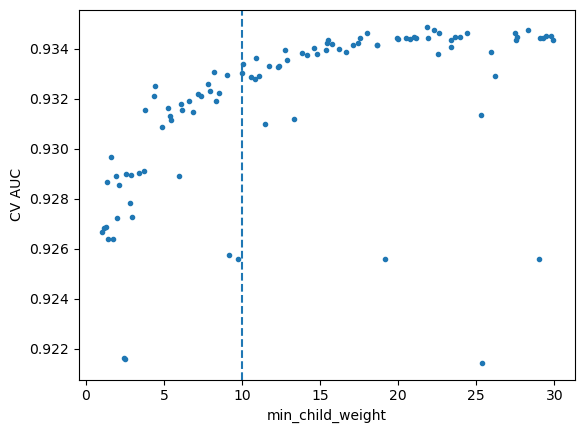

In [9]:
fig, ax = plt.subplots()
ax.plot(min_childs, aucs, '.')
ax.axvline(10, linestyle='--')
ax.set_xlabel('min_child_weight')
ax.set_ylabel('CV AUC')

Here we will find that an optimal subsample value would be 0.95 due to a malignly higher concentration of high preforming models. Most values seem to give good enough results.

Text(0, 0.5, 'CV AUC')

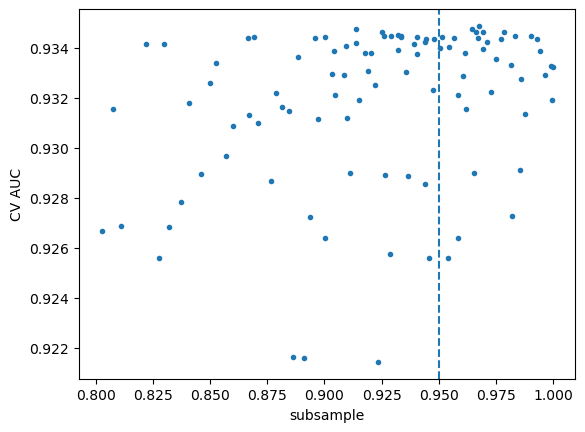

In [10]:
fig, ax = plt.subplots()
ax.plot(subsample, aucs, '.')
ax.axvline(.95, linestyle='--')
ax.set_xlabel('subsample')
ax.set_ylabel('CV AUC')

We can now determine, with these new values, what the optimal number of n_estimators is.

In [11]:
model = XGBClassifier(learning_rate = 0.06, 
                         max_depth = 15, 
                         subsample = 0.95,
                         min_child_weight = 10,
                         scale_pos_weight = trainingBalance)

score = xgb.cv(model.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", verbose_eval=True, num_boost_round=400)

[0]	train-auc:0.95199+0.00020	test-auc:0.92048+0.00265
[1]	train-auc:0.95976+0.00100	test-auc:0.92757+0.00161
[2]	train-auc:0.96281+0.00110	test-auc:0.93064+0.00185
[3]	train-auc:0.96488+0.00115	test-auc:0.93242+0.00135
[4]	train-auc:0.96646+0.00097	test-auc:0.93382+0.00166
[5]	train-auc:0.96769+0.00088	test-auc:0.93490+0.00142
[6]	train-auc:0.96869+0.00069	test-auc:0.93555+0.00139
[7]	train-auc:0.96957+0.00056	test-auc:0.93607+0.00149
[8]	train-auc:0.97032+0.00058	test-auc:0.93659+0.00152
[9]	train-auc:0.97104+0.00048	test-auc:0.93694+0.00155
[10]	train-auc:0.97175+0.00045	test-auc:0.93726+0.00156
[11]	train-auc:0.97232+0.00041	test-auc:0.93745+0.00156
[12]	train-auc:0.97284+0.00040	test-auc:0.93775+0.00147
[13]	train-auc:0.97340+0.00042	test-auc:0.93794+0.00146
[14]	train-auc:0.97394+0.00035	test-auc:0.93819+0.00142
[15]	train-auc:0.97444+0.00034	test-auc:0.93846+0.00137
[16]	train-auc:0.97496+0.00034	test-auc:0.93865+0.00143
[17]	train-auc:0.97546+0.00030	test-auc:0.93883+0.00141
[1

Here we will find that an optimal number of estimators would be about 125.

Text(0, 0.5, 'CV AUC score')

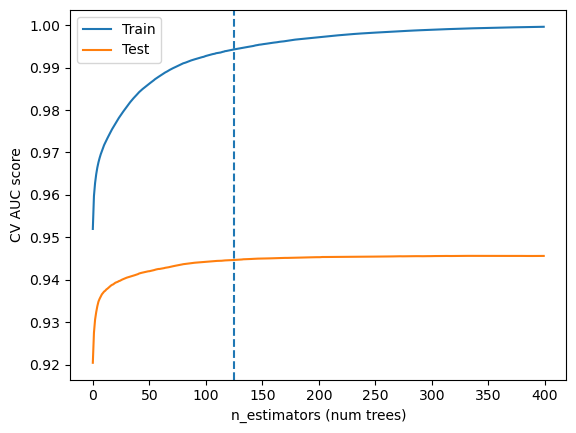

In [12]:
n_estimators = 125
fig, ax = plt.subplots()
ax.plot(score.index, score['train-auc-mean'], label='Train')
ax.plot(score.index, score['test-auc-mean'], label='Test')
ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

# SPOCK

We can now train the final spock model

In [17]:
from sklearn import metrics
from sklearn.metrics import roc_curve, confusion_matrix, auc
def ROC_curve( model, x,y):
    preds = model.predict_proba(x)[:,1]
    fpr, tpr, ROCthresholds = roc_curve(y, preds)
    roc_auc = metrics.roc_auc_score(y, preds)
    return roc_auc, fpr, tpr, ROCthresholds

In [14]:
model = XGBClassifier(learning_rate = 0.06, 
                         max_depth = 15, 
                         subsample = 0.95,
                         min_child_weight = 10,
                         n_estimators = 125,
                         scale_pos_weight=trainingBalance)

In [15]:
model.fit(trainX,trainY)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              n_estimators=125, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Text(0.5, 1.0, 'ROC curve (AUC = 0.947)')

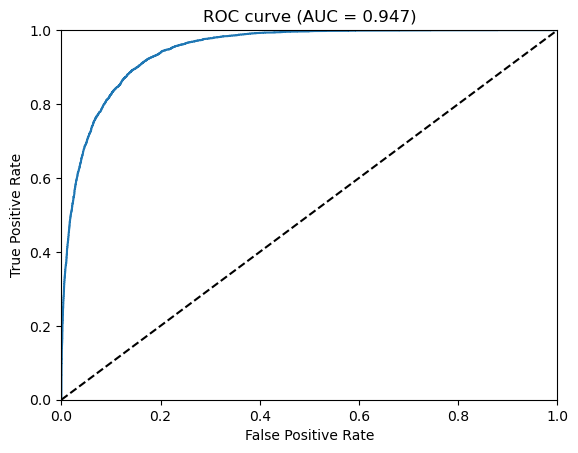

In [18]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(model, testX, testY)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

# Old REBOUND preforms less good then newer version

Here we can see the model trained and tested on the older version of rebound, preforms slightly less well then the model trained on the newer version of rebound. Since the newer version of rebound preforms better, it is at least comparable if not superior to the old version for the purposes of spock. Thus, for usability and longevity we will chose to implement spock with the new version of rebound (version 4+).